In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cdr3_surface_tool import *
from Bio import pairwise2
from functools import *

alphabet = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', \
            'G', 'H', 'I', 'L', 'K', 'M', 'F', \
            'P', 'S', 'T', 'W', 'Y', 'V']

In [2]:
def empty_aa_mat():
    return pd.DataFrame(np.nan, columns=alphabet, index=alphabet)

Here we fetch Miyazava energy table and make it diagonal.

In [3]:
nrg_mat = pd.DataFrame(pd.read_table('miyazava_table.txt'))
nrg_mat.index = nrg_mat.columns
# Make it diagonal
for i in range(nrg_mat.shape[0]):
    for j in range(i):
        nrg_mat.iloc[i, j] = nrg_mat.iloc[j, i]
nrg_mat.sort_index(0, inplace=True)
nrg_mat.sort_index(1, inplace=True)
#nrg_mat

In [4]:
# Fetch structural data, refine it a bit, and assign Myazava energy value to each pair
df = pd.DataFrame(pd.read_table('structure_refined.txt'))
df = df[df['tcr_region'] == 'CDR3']

df.loc[df.tcr_v_allele.str.startswith('TRA'), 'tcr_v_allele'] = 'alpha'
df.loc[df.tcr_v_allele.str.startswith('TRB'), 'tcr_v_allele'] = 'beta'
df['pos_tcr'] = df['pos_tcr'] - list(map(np.floor, (df['len_tcr'] / 2)))
df['pos_antigen'] = df['pos_antigen'] - list(map(np.floor, (df['len_antigen'] / 2)))
df.dropna(inplace=True)
df.index = range(df.shape[0])

df.loc[:, 'recalc_energy'] = 0
for x in range(df.shape[0]):
    df.iloc[x, -1] = nrg_mat.loc[df.iloc[x, -9], df.iloc[x, -8]]

** We will try to use Miyazava energy table to evaluate interaction energy between CDR3 and antigen **

Which amino acid pairs should be taken into account during energy calculation is not obvious, so it would be logical to try different functions and choose the one, which yields the biggest correlation in comparison with real energies derived from gromacs

In [21]:
# Each function yields a list of energies for each complex, so we get a Series of lists
def calc_energy1(grouped, ag_left=-4, ag_right=4, tcr_left=-4, tcr_right=4, tcr_range_min=2, tcr_range_max=4):
    rec_energy_beta = []
    energy_index = pd.MultiIndex.from_product([range(tcr_range_min, tcr_range_max + 1), 
                                               range(ag_left, ag_right + 1),
                                               range(tcr_left, tcr_right + 1)])             
    for name, group in grouped:
        group = group[group['tcr_v_allele'] == 'beta']
        group.index = range(group.shape[0])
        energy = []
        for tcr_range in range(tcr_range_min, tcr_range_max + 1):
            for ag_center in range(ag_left, ag_right + 1):
                for tcr_center in range(tcr_left, tcr_right + 1):
                    new_pos_tcr = group['pos_tcr'] - tcr_center
                    new_pos_antigen = group['pos_antigen'] - ag_center
                    energy_sum = 0
                    for i in range(len(new_pos_tcr)):
                        if (new_pos_tcr[i] > -tcr_range and new_pos_antigen[i] < tcr_range):
                            if (new_pos_tcr[i] == new_pos_antigen[i] - np.sign(new_pos_antigen[i])):
                                energy_sum += group.loc[i, 'recalc_energy']
                            else:
                                if (new_pos_tcr[i] == 0 and (new_pos_antigen[i] == -1 or new_pos_antigen[i] == 1)):
                                    energy_sum += group.loc[i, 'recalc_energy']
                    energy.append(energy_sum)
        rec_energy_beta.append(pd.Series(energy, index=energy_index))
        
    rec_energy = pd.Series(rec_energy_beta)# + pd.Series(rec_energy_alpha)
    rec_energy.index = grouped.groups.keys()
    return rec_energy

def calc_energy2(grouped, ag_left=-4, ag_right=4, tcr_left=-4, tcr_right=4, tcr_range_min=2, tcr_range_max=4):
    rec_energy_beta = []
    energy_index = pd.MultiIndex.from_product([range(tcr_range_min, tcr_range_max + 1), 
                                               range(ag_left, ag_right + 1),
                                               range(tcr_left, tcr_right + 1)])             
    for name, group in grouped:
        group = group[group['tcr_v_allele'] == 'beta']
        group.index = range(group.shape[0])
        energy = []
        for tcr_range in range(tcr_range_min, tcr_range_max + 1):
            for ag_center in range(ag_left, ag_right + 1):
                for tcr_center in range(tcr_left, tcr_right + 1):
                    new_pos_tcr = group['pos_tcr'] - tcr_center
                    new_pos_antigen = group['pos_antigen'] - ag_center
                    energy_sum = 0
                    for i in range(len(new_pos_tcr)):
                        if (new_pos_tcr[i] > -tcr_range and new_pos_antigen[i] < tcr_range):
                            if (new_pos_tcr[i] == new_pos_antigen[i]):
                                energy_sum += group.loc[i, 'recalc_energy']
                            else:
                                if (new_pos_tcr[i] == 0 and (new_pos_antigen[i] == -1 or new_pos_antigen[i] == 1)):
                                    energy_sum += group.loc[i, 'recalc_energy']
                    energy.append(energy_sum)
        rec_energy_beta.append(pd.Series(energy, index=energy_index))
        
    rec_energy = pd.Series(rec_energy_beta)# + pd.Series(rec_energy_alpha)
    rec_energy.index = grouped.groups.keys()
    return rec_energy

def calc_energy3(grouped, ag_left=-4, ag_right=4, tcr_left=-4, tcr_right=4, tcr_range_min=2, tcr_range_max=4):
    rec_energy_beta = []
    energy_index = pd.MultiIndex.from_product([range(tcr_range_min, tcr_range_max + 1), 
                                               range(ag_left, ag_right + 1),
                                               range(tcr_left, tcr_right + 1)])             
    for name, group in grouped:
        group = group[group['tcr_v_allele'] == 'beta']
        group.index = range(group.shape[0])
        energy = []
        for tcr_range in range(tcr_range_min, tcr_range_max + 1):
            for ag_center in range(ag_left, ag_right + 1):
                for tcr_center in range(tcr_left, tcr_right + 1):
                    new_pos_tcr = group['pos_tcr'] - tcr_center
                    new_pos_antigen = group['pos_antigen'] - ag_center
                    energy_sum = 0
                    for i in range(len(new_pos_tcr)):
                        if (new_pos_tcr[i] > -tcr_range and new_pos_antigen[i] < tcr_range):
                            if (new_pos_tcr[i] == new_pos_antigen[i] - np.sign(new_pos_antigen[i]) or \
                               new_pos_tcr[i] == new_pos_antigen[i]):
                                energy_sum += group.loc[i, 'recalc_energy']
                            else:
                                if (new_pos_tcr[i] == 0 and (new_pos_antigen[i] == -1 or new_pos_antigen[i] == 1)):
                                    energy_sum += group.loc[i, 'recalc_energy']
                    energy.append(energy_sum)
        rec_energy_beta.append(pd.Series(energy, index=energy_index))
        
    rec_energy = pd.Series(rec_energy_beta)# + pd.Series(rec_energy_alpha)
    rec_energy.index = grouped.groups.keys()
    return rec_energy

def calc_energy4(grouped, ag_left=-4, ag_right=4, tcr_left=-4, tcr_right=4, tcr_range_min=2, tcr_range_max=4):
    rec_energy_beta = []
    energy_index = pd.MultiIndex.from_product([range(tcr_range_min, tcr_range_max + 1), 
                                               range(ag_left, ag_right + 1),
                                               range(tcr_left, tcr_right + 1)])             
    for name, group in grouped:
        group = group[group['tcr_v_allele'] == 'beta']
        group.index = range(group.shape[0])
        energy = []
        for tcr_range in range(tcr_range_min, tcr_range_max + 1):
            for ag_center in range(ag_left, ag_right + 1):
                for tcr_center in range(tcr_left, tcr_right + 1):
                    new_pos_tcr = group['pos_tcr'] - tcr_center
                    new_pos_antigen = group['pos_antigen'] - ag_center
                    energy_sum = 0
                    for i in range(len(new_pos_tcr)):
                        if (new_pos_tcr[i] > -tcr_range and new_pos_antigen[i] < tcr_range):
                            if (new_pos_tcr[i] == new_pos_antigen[i] - 1 or \
                                new_pos_tcr[i] == new_pos_antigen[i] or \
                                new_pos_tcr[i] == new_pos_antigen[i] + 1):
                                energy_sum += group.loc[i, 'recalc_energy']
                    energy.append(energy_sum)
        rec_energy_beta.append(pd.Series(energy, index=energy_index))
        
    rec_energy = pd.Series(rec_energy_beta)# + pd.Series(rec_energy_alpha)
    rec_energy.index = grouped.groups.keys()
    return rec_energy

In [6]:
# CALCULATION IS LONG, DO NOT LAUNCH
# Calculate energies for each complex considering different positions as CDR3 and antigen centers
'''AG_LEFT_MAX = -4
AG_RIGHT_MAX = 4
TCR_LEFT_MAX = -4
TCR_RIGHT_MAX = 4
TCR_RANGE_MIN = 2
TCR_RANGE_MAX = 4
grouped = df.groupby('pdb_id')
rec_energy_arrays = calc_energy4(grouped, \
    AG_LEFT_MAX, AG_RIGHT_MAX, TCR_LEFT_MAX, TCR_RIGHT_MAX, TCR_RANGE_MIN, TCR_RANGE_MAX)'''

"AG_LEFT_MAX = -4\nAG_RIGHT_MAX = 4\nTCR_LEFT_MAX = -4\nTCR_RIGHT_MAX = 4\nTCR_RANGE_MIN = 2\nTCR_RANGE_MAX = 4\ngrouped = df.groupby('pdb_id')\nrec_energy_arrays = calc_energy4(grouped,     AG_LEFT_MAX, AG_RIGHT_MAX, TCR_LEFT_MAX, TCR_RIGHT_MAX, TCR_RANGE_MIN, TCR_RANGE_MAX)"

In [7]:
# Get minimum energy for each complex in different ranges for CDR3 and antigen center
'''index_list = []
rec_energy = []
pdb_names = grouped.groups.keys()
for tcr_range in range(TCR_RANGE_MIN, TCR_RANGE_MAX + 1):
    for ag_left in range(AG_LEFT_MAX, 1):
        for ag_right in range(0, AG_RIGHT_MAX + 1):
            for tcr_left in range(TCR_LEFT_MAX, 1):
                for tcr_right in range(0, TCR_RIGHT_MAX + 1):
                    index_list.append((ag_left, ag_right, tcr_left, tcr_right, tcr_range))
                    bufer = []
                    for array in rec_energy_arrays:
                        bufer.append(min(array.loc[tcr_range, ag_left:(ag_right + 1), tcr_left:(tcr_right + 1)]))
                    rec_energy.append(pd.Series(bufer, index=pdb_names))
rec_energy = pd.Series(rec_energy, index=index_list)'''

'index_list = []\nrec_energy = []\npdb_names = grouped.groups.keys()\nfor tcr_range in range(TCR_RANGE_MIN, TCR_RANGE_MAX + 1):\n    for ag_left in range(AG_LEFT_MAX, 1):\n        for ag_right in range(0, AG_RIGHT_MAX + 1):\n            for tcr_left in range(TCR_LEFT_MAX, 1):\n                for tcr_right in range(0, TCR_RIGHT_MAX + 1):\n                    index_list.append((ag_left, ag_right, tcr_left, tcr_right, tcr_range))\n                    bufer = []\n                    for array in rec_energy_arrays:\n                        bufer.append(min(array.loc[tcr_range, ag_left:(ag_right + 1), tcr_left:(tcr_right + 1)]))\n                    rec_energy.append(pd.Series(bufer, index=pdb_names))\nrec_energy = pd.Series(rec_energy, index=index_list)'

In [9]:
# Calculate correlation with real energies for different distance cut-offs 
'''pdb_names = grouped.groups.keys()
rea_energy10 = [sum(group.loc[(group['distance'] < 10) & (group['tcr_v_allele'] == 'beta') \
                            , 'energy']) for name, group in grouped]
rea_energy10 = pd.Series(rea_energy10, index=pdb_names)

f = open('corr_search4.txt', 'w')
f.write('ag_left,ag_right,tcr_left,tcr_right,tcr_range,corr5,corr6,corr7,corr8,corr9,corr10\n')
for tcr_range in range(TCR_RANGE_MIN, TCR_RANGE_MAX + 1):
    for ag_left in range(AG_LEFT_MAX, 1):
        for ag_right in range(0, AG_RIGHT_MAX + 1):
            for tcr_left in range(TCR_LEFT_MAX, 1):
                for tcr_right in range(0, TCR_RIGHT_MAX + 1):
                    corr10 = np.corrcoef(rea_energy10[rea_energy10 < 0], rec_energy[(ag_left, ag_right, tcr_left, tcr_right, tcr_range)][rea_energy10 < 0])
                    f.write('%i,%i,%i,%i,%i,%f\n' % (ag_left, ag_right, tcr_left, tcr_right, tcr_range, corr10[0, 1]))
f.close()'''

"pdb_names = grouped.groups.keys()\nrea_energy5 = [sum(group.loc[(group['distance'] < 5) & (group['tcr_v_allele'] == 'beta')                             , 'energy']) for name, group in grouped]\nrea_energy5 = pd.Series(rea_energy5, index=pdb_names)\nrea_energy6 = [sum(group.loc[(group['distance'] < 6) & (group['tcr_v_allele'] == 'beta')                             , 'energy']) for name, group in grouped]\nrea_energy6 = pd.Series(rea_energy6, index=pdb_names)\nrea_energy7 = [sum(group.loc[(group['distance'] < 7) & (group['tcr_v_allele'] == 'beta')                             , 'energy']) for name, group in grouped]\nrea_energy7 = pd.Series(rea_energy7, index=pdb_names)\nrea_energy8 = [sum(group.loc[(group['distance'] < 8) & (group['tcr_v_allele'] == 'beta')                             , 'energy']) for name, group in grouped]\nrea_energy8 = pd.Series(rea_energy8, index=pdb_names)\nrea_energy9 = [sum(group.loc[(group['distance'] < 9) & (group['tcr_v_allele'] == 'beta')                    

The biggest value of correlation coefficient was obtained using calc_energy2() 

In [224]:
corr_tl = pd.read_csv('corr_search2.txt')
corr_tl.groupby('tcr_range').get_group(3).sort_values('corr6', ascending=False).head()

,ag_left,ag_right,tcr_left,tcr_right,tcr_range,corr5,corr6,corr7,corr8,corr9,corr10
725,-2,1,-3,0,3,0.171745,0.183252,0.188127,0.188254,0.188575,0.188544
825,-1,1,-3,0,3,0.166216,0.180407,0.184655,0.184785,0.185202,0.185174
925,0,1,-3,0,3,0.162794,0.177019,0.180460,0.180783,0.181080,0.181052
720,-2,1,-4,0,3,0.161536,0.172819,0.177237,0.177330,0.177631,0.177599
625,-3,1,-3,0,3,0.161605,0.170266,0.175024,0.175067,0.175293,0.175262


It appears that the most reasonable CDR3 range in which amino acids are tested for being the CDR3 center is (-3, 0) which is quiet close to reality in the case of CDR3 beta. But nevertheless the greatest correlation values is 0.2 which means that energy values which are obtained using Miyazava table are very unreliable.

The pictures below show that the approach using Miyazava table is not feasible at all. Using staightforward method described above we calculate energies for complexes from the vdjdb.txt table and draw the energy distribution for the real case and the case where all the antigens are mixed up. Energy distribution for in both cases seems to be random and the mean value shifts to the lower energy values in case of mixed antigens, which sounds irrelevant.

In [5]:
columns = ['species', 'mhc_type', 'tcr_v_allele', 'cdr3', 'antigen','aa_tcr', 'aa_antigen', 'len_tcr', 'len_antigen', 'pos_tcr', 'pos_antigen', 'distance']
def process_single_line(line):
    id = line[-1]
    mhc_type = line['mhc.type']
    tcr_v_allele = line['gene']
    cdr3 = line['cdr3']
    antigen = line['antigen']
    species = line['species']
    len_tcr = len(cdr3)
    len_antigen = len(antigen)
    empty = pd.DataFrame(columns=['tcr_id'] + columns, index=range(len_tcr*len_antigen))
    
    for i in range(len_tcr):
        for j in range(len_antigen):
            cur_id = i*len_antigen + j
            empty.ix[cur_id, 'aa_tcr'] = cdr3[i]
            empty.ix[cur_id, 'aa_antigen'] = antigen[j]
            empty.ix[cur_id, 'pos_tcr'] = i
            empty.ix[cur_id, 'pos_antigen'] = j
            
    if tcr_v_allele == 'TRA':
        tcr_v_allele = 'alpha'
    if tcr_v_allele == 'TRB':
        tcr_v_allele = 'beta'
    empty['tcr_id'] = id
    empty['species'] = species
    empty['mhc_type'] = mhc_type
    empty['tcr_v_allele'] = tcr_v_allele
    empty['cdr3'] = cdr3
    empty['antigen'] = antigen
    empty['len_tcr'] = len_tcr
    empty['len_antigen'] = len_antigen
    empty['distance'] = np.nan
    empty['pos_tcr'] = empty['pos_tcr'] - list(map(np.floor, (empty['len_tcr'] / 2)))
    empty['pos_antigen'] = empty['pos_antigen'] - list(map(np.floor, (empty['len_antigen'] / 2)))
    return empty

In [6]:
vdjdb = pd.DataFrame(pd.read_table('vdjdb.txt'))
vdjdb = vdjdb[['cdr3', 'gene', 'species', 'mhc.type', 'antigen']]

vdjdb.dropna(inplace=True)
vdjdb = vdjdb.applymap(str.strip)
vdjdb.drop_duplicates(subset=['cdr3', 'antigen'], keep='first', inplace=True)
vdjdb = vdjdb[vdjdb['cdr3'].str.isalpha() & vdjdb['antigen'].str.isalpha()]
vdjdb.index = vdjdb['id'] = range(vdjdb.shape[0])

In [25]:
'''vdjdb_melt = pd.concat([process_single_line(vdjdb.iloc[x, :]) for x in range(vdjdb.shape[0])]) #vdjdb.shape[0]
vdjdb_melt['distance'] = True
vdjdb_melt.index = range(vdjdb_melt.shape[0])

grouped_mixed = vdjdb.groupby('antigen')
antigens = grouped_mixed.groups.keys()
def change_antigen_column(i):
    table = grouped_mixed.get_group(antigens[i])
    table.loc[:, 'antigen'] = antigens[i - 1]
    return table
vdjdb_mixed = pd.concat([change_antigen_column(i) for i in range(len(antigens))])
vdjdb_mixed.index = vdjdb_mixed['id'] = range(vdjdb_mixed.shape[0])
vdjdb_melt_mixed = pd.concat([process_single_line(vdjdb_mixed.iloc[x, :]) for x in range(vdjdb_mixed.shape[0])])
vdjdb_melt_mixed['distance'] = True
vdjdb_melt_mixed.index = range(vdjdb_melt_mixed.shape[0])'''

"vdjdb_melt = pd.concat([process_single_line(vdjdb.iloc[x, :]) for x in range(vdjdb.shape[0])]) #vdjdb.shape[0]\nvdjdb_melt['distance'] = True\nvdjdb_melt.index = range(vdjdb_melt.shape[0])\n\ngrouped_mixed = vdjdb.groupby('antigen')\nantigens = grouped_mixed.groups.keys()\ndef change_antigen_column(i):\n    table = grouped_mixed.get_group(antigens[i])\n    table.loc[:, 'antigen'] = antigens[i - 1]\n    return table\nvdjdb_mixed = pd.concat([change_antigen_column(i) for i in range(len(antigens))])\nvdjdb_mixed.index = vdjdb_mixed['id'] = range(vdjdb_mixed.shape[0])\nvdjdb_melt_mixed = pd.concat([process_single_line(vdjdb_mixed.iloc[x, :]) for x in range(vdjdb_mixed.shape[0])])\nvdjdb_melt_mixed['distance'] = True\nvdjdb_melt_mixed.index = range(vdjdb_melt_mixed.shape[0])"

In [26]:
'''vdjdb_melt.loc[:, 'recalc_energy'] = 0
for x in vdjdb_melt.index:
    vdjdb_melt.ix[x, 'recalc_energy'] = nrg_mat.loc[vdjdb_melt.ix[x, 'aa_tcr'], vdjdb_melt.ix[x, 'aa_antigen']]

vdjdb_melt_mixed.loc[:, 'recalc_energy'] = 0
for x in vdjdb_melt_mixed.index:
    vdjdb_melt_mixed.ix[x, 'recalc_energy'] = nrg_mat.loc[vdjdb_melt_mixed.ix[x, 'aa_tcr'], vdjdb_melt_mixed.ix[x, 'aa_antigen']]

vdjdb_melt.to_csv('vdjdb_melt.csv', index=False)
vdjdb_melt_mixed.to_csv('vdjdb_melt_mixed.csv', index=False)'''

"vdjdb_melt.loc[:, 'recalc_energy'] = 0\nfor x in vdjdb_melt.index:\n    vdjdb_melt.ix[x, 'recalc_energy'] = nrg_mat.loc[vdjdb_melt.ix[x, 'aa_tcr'], vdjdb_melt.ix[x, 'aa_antigen']]\n\nvdjdb_melt_mixed.loc[:, 'recalc_energy'] = 0\nfor x in vdjdb_melt_mixed.index:\n    vdjdb_melt_mixed.ix[x, 'recalc_energy'] = nrg_mat.loc[vdjdb_melt_mixed.ix[x, 'aa_tcr'], vdjdb_melt_mixed.ix[x, 'aa_antigen']]\n\nvdjdb_melt.to_csv('vdjdb_melt.csv', index=False)\nvdjdb_melt_mixed.to_csv('vdjdb_melt_mixed.csv', index=False)"

In [7]:
# choise of function for energy calculation is based on previous study
def calc_energy_final(grouped, ag_left=-2, ag_right=3, tcr_left=-3, tcr_right=0, tcr_range_min=3, tcr_range_max=3):
    return calc_energy2(grouped, ag_left, ag_right, tcr_left, tcr_right, tcr_range_min, tcr_range_max)

In [8]:
vdjdb_melt = pd.read_csv('vdjdb_melt.csv')
vdjdb_melt_mixed = pd.read_csv('vdjdb_melt_mixed.csv')
vdjdb_melt = vdjdb_melt[vdjdb_melt['tcr_v_allele'] == 'beta']
vdjdb_melt_mixed = vdjdb_melt_mixed[vdjdb_melt_mixed['tcr_v_allele'] == 'beta']

In [29]:
'''grouped_unmix = vdjdb_melt.groupby('tcr_id')
grouped_mix = vdjdb_melt_mixed.groupby('tcr_id')
unmixed_energy_many = calc_energy_final(grouped_unmix)
mixed_energy_many = calc_energy_final(grouped_mix)'''

"grouped_unmix = vdjdb_melt.groupby('tcr_id')\ngrouped_mix = vdjdb_melt_mixed.groupby('tcr_id')\nunmixed_energy_many = calc_energy_final(grouped_unmix)\nmixed_energy_many = calc_energy_final(grouped_mix)"

In [30]:
'''unmixed_energy_min = [min(unmixed_energy_many[i]) for i in range(len(unmixed_energy_many))]
mixed_energy_min = [min(mixed_energy_many[i]) for i in range(len(mixed_energy_many))]
ax = sns.distplot(unmixed_energy_min, bins=60, kde=True, label='unmixed')       
plt.axvline(np.mean(unmixed_energy_min), color=ax.get_lines()[0].get_c(), label='unmixed mean')
ax = sns.distplot(mixed_energy_min, bins=60, kde=True, label='mixed')       
plt.axvline(np.mean(mixed_energy_min), color=ax.get_lines()[2].get_c(), label='mixed mean')
plt.xlabel('Calculated energy'); plt.legend();'''

"unmixed_energy_min = [min(unmixed_energy_many[i]) for i in range(len(unmixed_energy_many))]\nmixed_energy_min = [min(mixed_energy_many[i]) for i in range(len(mixed_energy_many))]\nax = sns.distplot(unmixed_energy_min, bins=60, kde=True, label='unmixed')       \nplt.axvline(np.mean(unmixed_energy_min), color=ax.get_lines()[0].get_c(), label='unmixed mean')\nax = sns.distplot(mixed_energy_min, bins=60, kde=True, label='mixed')       \nplt.axvline(np.mean(mixed_energy_min), color=ax.get_lines()[2].get_c(), label='mixed mean')\nplt.xlabel('Calculated energy'); plt.legend();"

In [9]:
vdjdb.groupby('antigen').count().iloc[:, 0]

antigen
ARNLVPMVATVQGQN      3
CTPYDINQM          401
EDVPSGKLFMHVTLG      1
EIYKRWII            38
ELRRKMMYM           10
EPLPQGQLTAY         50
FLKEKGGL            76
FLKEMGGL             7
FLKEQGGL             7
FLKETGGL             7
FLRGRAYGL           18
GLCTLVAML          107
GLNKIVRMY           28
HPVGEADYFEY          7
ILKEPVHGV           19
IPSINVHHY           21
ISPRTLNAW           10
KAFSPEVIPMF         42
KIFGSLAFL            2
KRWIILGLNK          16
LPEPLPQGQLTAY        8
LSEFCRVLCCYVLEE      2
NLVPMVATV          263
QASQEVKNW            4
QIKVRVDMV           22
QVPLRPMTYK          19
RAKFKQLL            55
RMFPNAPYL           10
RPRGEVRFL           67
TPRVTGGGAM          57
TQGYFPDWQNY          6
TTPESANL           514
YSEHPTFTSQY         10
Name: cdr3, dtype: int64

In [10]:
# original - antigen sequence in vdjdb
# mutant - any sequence
#
# this function assignes to "mutant" antigen those cdr3s, which correspond to "original" antigen, 
# and calculates energies for each cdr3
#
# single_cdr3 - if < 0, then do for all cdr3; if >= 0, then do for one cdr3,
# which stands under the corresponding serial number in the list of cdr3s
#
def get_mutant(original, mutant, single_cdr3=-1):
    table = vdjdb[vdjdb['antigen'] == original].copy()
    table['antigen'] = mutant
    table = table[table['gene'] == 'TRB']
    rng = range(table.shape[0])
    if (single_cdr3 >= 0):
        rng = [single_cdr3]
    table = pd.concat([process_single_line(table.iloc[x, :]) for x in rng])
    table['distance'] = True
    table.index = range(table.shape[0])
    table['recalc_energy'] = 0
    for x in table.index:
        table.ix[x, 'recalc_energy'] = nrg_mat.loc[table.ix[x, 'aa_tcr'], table.ix[x, 'aa_antigen']]
    table_grouped = table.groupby('tcr_id')
    return calc_energy_final(table_grouped)

Now one amino acid in TTPESANL is changed and energy for all cdr3s is calculated for each case

In [32]:
TTPESANL_energy_many = get_mutant('TTPESANL', 'TTPESANL')
TTPESANL_mutant_energy_many = get_mutant('TTPESANL', 'TTPEGANL')

In [33]:
TTPRGANL_mutant_energy_many = get_mutant('TTPESANL', 'TTPRGANL')

In [34]:
TTPKYANL_mutant_energy_many = get_mutant('TTPESANL', 'TTPKYANL')

In [35]:
TTPRRANL_mutant_energy_many = get_mutant('TTPESANL', 'TTPRRANL')

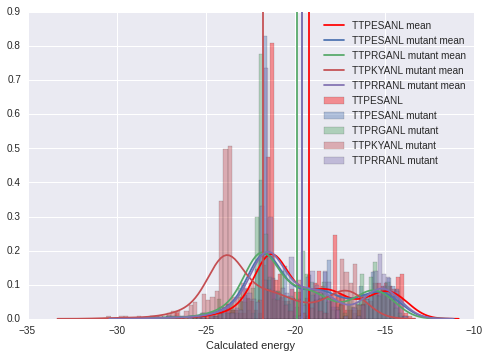

In [36]:
energy_mins = [min(x) for x in TTPESANL_energy_many]
ax = sns.distplot(energy_mins, bins=60, kde=True, label='TTPESANL', color='red')       
plt.axvline(np.mean(energy_mins), c=ax.get_lines()[0].get_c(), label='TTPESANL mean')

energy_mins = [min(x) for x in TTPESANL_mutant_energy_many]
sns.distplot(energy_mins, bins=60, kde=True, label='TTPESANL mutant')       
plt.axvline(np.mean(energy_mins), c=ax.get_lines()[2].get_c(), label='TTPESANL mutant mean')

energy_mins = [min(x) for x in TTPRGANL_mutant_energy_many]
sns.distplot(energy_mins, bins=60, kde=True, label='TTPRGANL mutant')       
plt.axvline(np.mean(energy_mins), c=ax.get_lines()[4].get_c(), label='TTPRGANL mutant mean')

energy_mins = [min(x) for x in TTPKYANL_mutant_energy_many]
sns.distplot(energy_mins, bins=60, kde=True, label='TTPKYANL mutant')       
plt.axvline(np.mean(energy_mins), c=ax.get_lines()[6].get_c(), label='TTPKYANL mutant mean')

energy_mins = [min(x) for x in TTPRRANL_mutant_energy_many]
sns.distplot(energy_mins, bins=60, kde=True, label='TTPRRANL mutant')       
plt.axvline(np.mean(energy_mins), c=ax.get_lines()[8].get_c(), label='TTPRRANL mutant mean')

plt.xlabel('Calculated energy'); plt.legend();

Now we plot energies for FLKEKGGL FLKEMGGL FLKEQGGL FLKETGGL. These are interesting because they share indentical cdr3s so there is no difference which one of them to choose as "original", and their antigen sequences differ by single amino acid

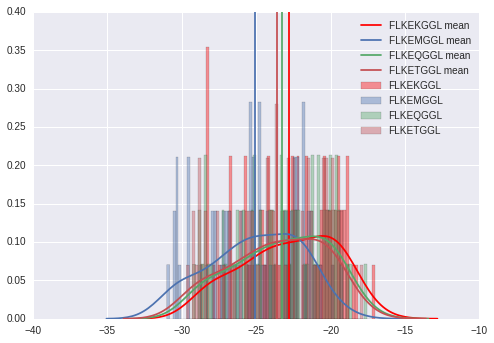

In [37]:
energy_mins = [min(x) for x in get_mutant('FLKEKGGL', 'FLKEKGGL')]
ax = sns.distplot(energy_mins, bins=60, kde=True, label='FLKEKGGL', color='red')       
plt.axvline(np.mean(energy_mins), c=ax.get_lines()[0].get_c(), label='FLKEKGGL mean')

energy_mins = [min(x) for x in get_mutant('FLKEKGGL', 'FLKEMGGL')]
sns.distplot(energy_mins, bins=60, kde=True, label='FLKEMGGL')       
plt.axvline(np.mean(energy_mins), c=ax.get_lines()[2].get_c(), label='FLKEMGGL mean')

energy_mins = [min(x) for x in get_mutant('FLKEKGGL', 'FLKEQGGL')]
sns.distplot(energy_mins, bins=60, kde=True, label='FLKEQGGL')       
plt.axvline(np.mean(energy_mins), c=ax.get_lines()[4].get_c(), label='FLKEQGGL mean')

energy_mins = [min(x) for x in get_mutant('FLKEKGGL', 'FLKETGGL')]
sns.distplot(energy_mins, bins=60, kde=True, label='FLKETGGL')       
plt.axvline(np.mean(energy_mins), c=ax.get_lines()[6].get_c(), label='FLKETGGL mean')
plt.legend()

Now we plot energy means for these four antigens and then assign three false antigens to their cdr3 and plot kde's for them

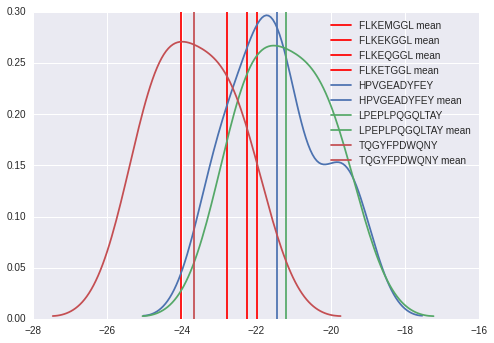

In [20]:

energy_mins = [min(x) for x in get_mutant('FLKEMGGL', 'FLKEMGGL')]     
plt.axvline(np.mean(energy_mins), c='red', label='FLKEMGGL mean')

energy_mins = [min(x) for x in get_mutant('FLKEKGGL', 'FLKEKGGL')]      
plt.axvline(np.mean(energy_mins), c='red', label='FLKEKGGL mean')

energy_mins = [min(x) for x in get_mutant('FLKEQGGL', 'FLKEQGGL')]   
plt.axvline(np.mean(energy_mins), c='red', label='FLKEQGGL mean')

energy_mins = [min(x) for x in get_mutant('FLKETGGL', 'FLKETGGL')]     
plt.axvline(np.mean(energy_mins), c='red', label='FLKETGGL mean')

energy_mins = [min(x) for x in get_mutant('FLKEMGGL', 'HPVGEADYFEY')]
ax = sns.kdeplot(np.array(energy_mins), shade=False, label='HPVGEADYFEY')       
plt.axvline(np.mean(energy_mins), c=ax.get_lines()[-1].get_c(), label='HPVGEADYFEY mean')

energy_mins = [min(x) for x in get_mutant('FLKEMGGL', 'LPEPLPQGQLTAY')]
ax = sns.kdeplot(np.array(energy_mins), shade=False, label='LPEPLPQGQLTAY')       
plt.axvline(np.mean(energy_mins), c=ax.get_lines()[-1].get_c(), label='LPEPLPQGQLTAY mean')

energy_mins = [min(x) for x in get_mutant('FLKEMGGL', 'TQGYFPDWQNY')]
ax = sns.kdeplot(np.array(energy_mins), shade=False, label='TQGYFPDWQNY')       
plt.axvline(np.mean(energy_mins), c=ax.get_lines()[-1].get_c(), label='TQGYFPDWQNY mean')
plt.legend()

So we see that false and true antigens are not distinguishable at all

** Maybe it is reasonable to use Bryant table instead of Myazava **

To do so we need to figure out the pairwise distance distribution relative to the center of CDR3 because unlike Miyazava table, Bryant table has different values for particular distance range. The center of CDR3 does not neccessarily lie in the geometric center, so a particular amino acid in CDR3 will be considered as center, if it is the closest one to antigen.

In [11]:
# It is usefull to look at the CDR3 centers distribution first
centers = [group.loc[group['distance'] == min(group['distance']), 'pos_tcr'].iloc[0] \
           for name, group in df[df['tcr_v_allele'] == 'beta'].groupby('pdb_id') if min(group['distance']) < 15]
pd.Series(centers).describe()

count    81.000000
mean     -7.234568
std       1.811571
min     -13.000000
25%      -8.000000
50%      -7.000000
75%      -6.000000
max      -4.000000
dtype: float64

In [12]:
def empty_mat():
    return pd.DataFrame(0.0, index=range(-15, 15), columns=range(-15, 15))

def get_distance_mat(group):
    min_dist = min(group['distance'])
    cdr3_center = group.loc[group['distance'] == min(group['distance']), 'pos_tcr'].iloc[0]
    anti_center = group.loc[group['distance'] == min(group['distance']), 'pos_antigen'].iloc[0]
    t = group.copy()
    t['pos_tcr'] -= cdr3_center
    t['pos_antigen'] -= anti_center
    t = t.pivot(index='pos_antigen', columns='pos_tcr', values='distance')
    mklist = lambda x: [x]
    return empty_mat().add(t, fill_value=0.0).applymap(mklist)
    
dist_mats = [get_distance_mat(group) for name, group in \
     df[df['tcr_v_allele'] == 'alpha'].groupby('pdb_id') if min(group['distance']) < 10]
dist_mats = [x.applymap(lambda x: list(filter(lambda a: a != 0.0, x))) for x in dist_mats]
dist_mats = reduce(lambda x, y: x + y, dist_mats)

In [13]:
vari_mat = dist_mats.applymap(lambda x: np.sqrt(np.var(x)))
mean_mat = dist_mats.applymap(np.mean)

C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


The table below shows mean distance and variance for each pair of positions, relative to the pair with minimal distance denoted as (0, 0).
We can see now for which distance range energy values should be taken from the Bryant table for each pair of amino acid positions while calculating energy

In [14]:
mean_mat.loc[-5:6, -5:6]

,-5,-4,-3,-2,-1,0,1,2,3,4,5,6
-5.0,16.555556,14.182476,15.029458,14.036251,14.496411,15.264832,16.406191,18.182171,18.397444,20.966289,20.457619,20.982086
-4.0,19.129947,17.776912,17.824995,16.082136,14.418023,14.036389,15.393391,17.184670,18.630298,20.801053,22.297804,21.379050
-3.0,19.353811,17.500756,15.953114,14.408921,11.917848,10.699507,13.371193,14.985069,15.758747,18.318110,20.041500,19.366047
-2.0,21.278914,18.453269,17.126730,14.148637,12.082602,9.435957,12.108824,13.470411,14.935353,17.779653,19.377608,19.682517
-1.0,21.143011,18.447975,17.121244,14.462784,12.554211,9.343242,12.553157,14.431086,15.665556,18.306260,19.778419,20.399489
0.0,17.505338,14.775493,12.966597,10.007947,8.671294,4.700289,8.484854,10.302018,11.453481,13.831006,14.929901,15.603823
1.0,21.014641,17.916318,16.645797,13.601711,12.763047,9.238591,11.897797,13.503964,14.423534,16.982059,17.756307,19.106153
2.0,21.053465,17.819452,17.293577,14.154245,13.471493,10.216647,12.824942,13.632682,14.828454,17.364644,18.262395,19.754502
3.0,21.595168,18.370300,18.230364,15.001331,15.205136,12.035601,13.593600,14.287978,15.202914,17.551153,17.654552,19.612171
4.0,25.806307,22.310458,22.155604,18.742082,18.958996,16.024023,17.338266,17.666822,18.500128,20.996446,21.258481,23.373321


In [15]:
vari_mat.loc[-5:6, -5:6]

,-5,-4,-3,-2,-1,0,1,2,3,4,5,6
-5.0,5.436863,5.141472,4.430325,4.729664,3.732288,3.121178,4.101970,5.033904,4.746997,5.214864,6.846036,5.056763
-4.0,7.952029,6.799091,4.499364,4.317511,2.474137,2.102055,3.559066,3.904661,3.648235,3.839356,4.415705,5.229358
-3.0,5.340317,4.830065,4.435993,3.984766,3.207542,2.142280,2.840756,3.637867,3.552680,3.214341,3.230728,4.127077
-2.0,5.261448,4.416311,4.004439,3.404537,3.327820,2.482952,3.254563,3.846980,3.887655,3.863369,3.594451,4.321573
-1.0,5.087261,3.879896,3.585808,2.967271,3.013180,2.148142,3.208215,3.079261,3.472522,3.402483,3.416084,3.868077
0.0,3.517892,3.224213,3.006455,2.376865,2.214235,1.469136,2.250702,2.502456,3.298489,3.131929,3.236916,3.286167
1.0,3.996399,3.465106,3.629317,3.174944,2.865011,2.006836,3.988880,3.434674,4.236912,4.370419,4.076201,4.035118
2.0,4.902302,4.401951,4.729645,3.464182,4.071620,2.543428,3.810596,3.914557,4.327909,4.596781,3.984462,3.757330
3.0,3.971501,3.302257,5.113362,3.879604,4.032446,2.686902,4.379555,4.360604,5.111738,5.186426,3.913827,3.725773
4.0,4.617666,3.666970,5.058236,3.403296,4.070586,2.550568,4.668180,4.795073,5.573200,5.788762,4.368985,3.809417


In [16]:
bryant = pd.read_csv('bryant_table_pairwise_nice.txt', index_col=[0,1])
#bryant.loc['A', 'A'].iloc[:6]

In [17]:
# wrapper
def get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, pos_cdr3, pos_anti, dist):
    if (pos_anti in list(new_pos_anti)) and (pos_cdr3 in list(new_pos_cdr3)):
        group.loc[new_pos_anti == pos_anti, 'aa_antigen'].iloc[-1]
        group.loc[new_pos_cdr3 == pos_cdr3, 'aa_tcr'].iloc[-1]
        return bryant.loc[group.loc[new_pos_anti == pos_anti, 'aa_antigen'].iloc[-1], \
                      group.loc[new_pos_cdr3 == pos_cdr3, 'aa_tcr'].iloc[-1]][dist]
    return 0

def calc_energy_bryant1(grouped, ag_left=-4, ag_right=4, tcr_left=-4, tcr_right=4):
    rec_energy_beta = []
    energy_index = pd.MultiIndex.from_product([range(ag_left, ag_right + 1),
                                               range(tcr_left, tcr_right + 1)])             
    for name, group in grouped:
        group = group[group['tcr_v_allele'] == 'beta']
        group.index = range(group.shape[0])
        aa_cdr3 = group['aa_tcr']
        aa_anti = group['aa_antigen']
        energy = []
        for ag_center in range(ag_left, ag_right + 1):
            for tcr_center in range(tcr_left, tcr_right + 1):
                new_pos_cdr3 = group['pos_tcr'] - tcr_center
                new_pos_anti = group['pos_antigen'] - ag_center
                energy_sum = 0
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, -2, 0, '9-10')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, -1, 0, '7-8')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, -1, 1, '9-10')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, 0, -3, '9-10')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, 0, -2, '8-9')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, 0, -1, '8-9')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, 0, 0, '0-5')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, 0, 1, '8-9')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, 0, 2, '9-10')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, 0, 3, '9-10')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, 1, -2, '9-10')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, 1, -1, '9-10')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, 1, 0, '7-8')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, 1, 1, '9-10')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, 2, 0, '9-10')
                energy.append(energy_sum)
        rec_energy_beta.append(pd.Series(energy, index=energy_index))
        
    rec_energy = pd.Series(rec_energy_beta)# + pd.Series(rec_energy_alpha)
    rec_energy.index = grouped.groups.keys()
    return rec_energy

def get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, pos_cdr3, pos_anti, min_dist, max_dist, overrange=False):
    if (pos_anti in list(new_pos_anti)) and (pos_cdr3 in list(new_pos_cdr3)):
        group.loc[new_pos_anti == pos_anti, 'aa_antigen'].iloc[-1]
        group.loc[new_pos_cdr3 == pos_cdr3, 'aa_tcr'].iloc[-1]
        if overrange:
            return min(min(bryant.loc[group.loc[new_pos_anti == pos_anti, 'aa_antigen'].iloc[-1], \
                      group.loc[new_pos_cdr3 == pos_cdr3, 'aa_tcr'].iloc[-1]].iloc[min_dist:max_dist + 1]), 0.0)
        return min(bryant.loc[group.loc[new_pos_anti == pos_anti, 'aa_antigen'].iloc[-1], \
                      group.loc[new_pos_cdr3 == pos_cdr3, 'aa_tcr'].iloc[-1]].iloc[min_dist:max_dist + 1])
    return 0

def calc_energy_bryant2(grouped, ag_left=-4, ag_right=4, tcr_left=-4, tcr_right=4):
    rec_energy_beta = []
    energy_index = pd.MultiIndex.from_product([range(ag_left, ag_right + 1),
                                               range(tcr_left, tcr_right + 1)])             
    for name, group in grouped:
        group = group[group['tcr_v_allele'] == 'beta']
        group.index = range(group.shape[0])
        aa_cdr3 = group['aa_tcr']
        aa_anti = group['aa_antigen']
        energy = []
        for ag_center in range(ag_left, ag_right + 1):
            for tcr_center in range(tcr_left, tcr_right + 1):
                new_pos_cdr3 = group['pos_tcr'] - tcr_center
                new_pos_anti = group['pos_antigen'] - ag_center
                energy_sum = 0
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, -2, 0, 3, 5)
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, -1, 0, 2, 5)
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, -1, 1, 2, 5, True) #
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, 0, -3, 4, 5, True) ##
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, 0, -2, 2, 5, True) #
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, 0, -1, 2, 5, True) #
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, 0, 0, 0, 1)
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, 0, 1, 3, 5)
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, 0, 2, 4, 5, True) ##
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, 0, 3, 5, 5, True) ##
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, 1, -2, 3, 5, True) ##
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, 1, -1, 4, 5, True) ##
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, 1, 0, 2, 5, True)
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, 1, 1, 3, 5, True) ##
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, 2, 0, 3, 5, True) ##
                energy.append(energy_sum)
        rec_energy_beta.append(pd.Series(energy, index=energy_index))
        
    rec_energy = pd.Series(rec_energy_beta)# + pd.Series(rec_energy_alpha)
    rec_energy.index = grouped.groups.keys()
    return rec_energy

def calc_energy_bryant3(grouped, ag_left=-4, ag_right=4, tcr_left=-4, tcr_right=4):
    rec_energy_alpha = []
    energy_index = pd.MultiIndex.from_product([range(ag_left, ag_right + 1),
                                               range(tcr_left, tcr_right + 1)])             
    for name, group in grouped:
        group = group[group['tcr_v_allele'] == 'alpha']
        group.index = range(group.shape[0])
        aa_cdr3 = group['aa_tcr']
        aa_anti = group['aa_antigen']
        energy = []
        for ag_center in range(ag_left, ag_right + 1):
            for tcr_center in range(tcr_left, tcr_right + 1):
                new_pos_cdr3 = group['pos_tcr'] - tcr_center
                new_pos_anti = group['pos_antigen'] - ag_center
                energy_sum = 0
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, -2, 0, '9-10')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, -1, 0, '8-9')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, 0, -3, '9-10')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, 0, -2, '9-10')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, 0, -1, '9-10')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, 0, 0, '0-5')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, 0, 1, '9-10')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, 0, 2, '9-10')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, 1, 0, '8-9')
                energy_sum += get_energy_from_bryant(group, new_pos_cdr3, new_pos_anti, 2, 0, '9-10')
                energy.append(energy_sum)
        rec_energy_alpha.append(pd.Series(energy, index=energy_index))
        
    rec_energy = pd.Series(rec_energy_alpha)
    rec_energy.index = grouped.groups.keys()
    return rec_energy

def calc_energy_bryant4(grouped, ag_left=-4, ag_right=4, tcr_left=-4, tcr_right=4):
    rec_energy_alpha = []
    energy_index = pd.MultiIndex.from_product([range(ag_left, ag_right + 1),
                                               range(tcr_left, tcr_right + 1)])             
    for name, group in grouped:
        group = group[group['tcr_v_allele'] == 'alpha']
        group.index = range(group.shape[0])
        aa_cdr3 = group['aa_tcr']
        aa_anti = group['aa_antigen']
        energy = []
        for ag_center in range(ag_left, ag_right + 1):
            for tcr_center in range(tcr_left, tcr_right + 1):
                new_pos_cdr3 = group['pos_tcr'] - tcr_center
                new_pos_anti = group['pos_antigen'] - ag_center
                energy_sum = 0
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, -2, 0, 3, 5, 1)
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, -1, 0, 2, 5)
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, 0, -3, 3, 5, 1)
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, 0, -2, 3, 5, 1)
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, 0, -1, 3, 5, 1)
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, 0, 0, 0, 1)
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, 0, 1, 3, 5, 1)
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, 0, 2, 3, 5, 1)
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, 1, 0, 2, 5)
                energy_sum += get_energy_from_bryant2(group, new_pos_cdr3, new_pos_anti, 2, 0, 3, 5, 1)
                energy.append(energy_sum)
        rec_energy_alpha.append(pd.Series(energy, index=energy_index))
        
    rec_energy = pd.Series(rec_energy_alpha)
    rec_energy.index = grouped.groups.keys()
    return rec_energy

In [18]:
AG_LEFT_MAX = -4
AG_RIGHT_MAX = 1
TCR_LEFT_MAX = -4
TCR_RIGHT_MAX = 4
grouped = df.groupby('pdb_id')
bryant_energy_alpha = calc_energy_bryant3(grouped, AG_LEFT_MAX, AG_RIGHT_MAX, TCR_LEFT_MAX, TCR_RIGHT_MAX)

In [19]:
index_list = []
rec_energy_alpha = []
pdb_names = grouped.groups.keys()
for ag_left in range(AG_LEFT_MAX, 1):
    for ag_right in range(0, AG_RIGHT_MAX + 1):
        for tcr_left in range(TCR_LEFT_MAX, 1):
            for tcr_right in range(0, TCR_RIGHT_MAX + 1):
                index_list.append((ag_left, ag_right, tcr_left, tcr_right))
                bufer = []
                for array in bryant_energy_alpha:
                    bufer.append(min(array.loc[ag_left:(ag_right + 1), tcr_left:(tcr_right + 1)]))
                rec_energy_alpha.append(pd.Series(bufer, index=pdb_names))
rec_energy_alpha = pd.Series(rec_energy_alpha, index=index_list)

In [20]:
pdb_names = grouped.groups.keys()
rea_energy_alpha = [sum(group.loc[group['tcr_v_allele'] == 'alpha', 'energy']) for name, group in grouped]
rea_energy_alpha = pd.Series(rea_energy_alpha, index=pdb_names)

f = open('corr_search_bryant_alpha.txt', 'w')
f.write('ag_left,ag_right,tcr_left,tcr_right,corr10\n')
for ag_left in range(AG_LEFT_MAX, 1):
    for ag_right in range(0, AG_RIGHT_MAX + 1):
        for tcr_left in range(TCR_LEFT_MAX, 1):
            for tcr_right in range(0, TCR_RIGHT_MAX + 1):
                corr10 = np.corrcoef(rea_energy_alpha, 
                                     rec_energy_alpha[(ag_left, ag_right, tcr_left, tcr_right)])
                f.write('%i,%i,%i,%i,%f\n' % (ag_left, ag_right, tcr_left, tcr_right, corr10[0, 1]))
f.close()

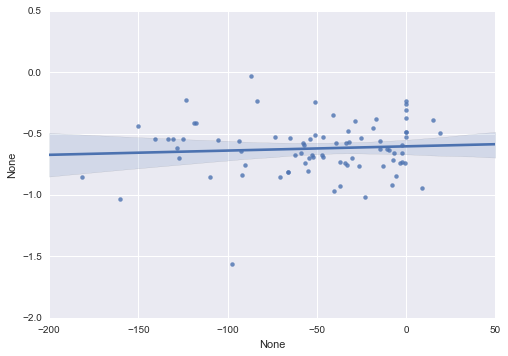

In [22]:
sns.regplot(rea_energy_alpha, rec_energy_alpha[(-2, 1, -4, 4)])

In [23]:
corr_tl = pd.read_csv('corr_search_bryant_alpha.txt')
ff = corr_tl.sort_values('corr10', ascending=False)
#ff[(ff.tcr_left == -1) & (ff.tcr_right == 1) ]
ff

,ag_left,ag_right,tcr_left,tcr_right,corr10
205,0,0,-3,0,0.103914
206,0,0,-3,1,0.103914
207,0,0,-3,2,0.103914
208,0,0,-3,3,0.103914
234,0,1,-3,4,0.103914
233,0,1,-3,3,0.103914
232,0,1,-3,2,0.103914
231,0,1,-3,1,0.103914
230,0,1,-3,0,0.103914
209,0,0,-3,4,0.103914


In [24]:
AG_LEFT_MAX = -4
AG_RIGHT_MAX = 4
TCR_LEFT_MAX = -4
TCR_RIGHT_MAX = 4
grouped = df.groupby('pdb_id')
bryant_energy_beta = calc_energy_bryant1(grouped, AG_LEFT_MAX, AG_RIGHT_MAX, TCR_LEFT_MAX, TCR_RIGHT_MAX)

In [25]:
index_list = []
rec_energy_beta = []
pdb_names = grouped.groups.keys()
for ag_left in range(AG_LEFT_MAX, 1):
    for ag_right in range(0, AG_RIGHT_MAX + 1):
        for tcr_left in range(TCR_LEFT_MAX, 1):
            for tcr_right in range(0, TCR_RIGHT_MAX + 1):
                index_list.append((ag_left, ag_right, tcr_left, tcr_right))
                bufer = []
                for array in bryant_energy_beta:
                    bufer.append(min(array.loc[ag_left:(ag_right + 1), tcr_left:(tcr_right + 1)]))
                rec_energy_beta.append(pd.Series(bufer, index=pdb_names))
rec_energy_beta = pd.Series(rec_energy_beta, index=index_list)

In [28]:
pdb_names = grouped.groups.keys()
rea_energy_beta = [sum(group.loc[group['tcr_v_allele'] == 'beta', 'energy']) for name, group in grouped]
rea_energy_beta = pd.Series(rea_energy_beta, index=pdb_names)

f = open('corr_search_bryant_beta.txt', 'w')
f.write('ag_left,ag_right,tcr_left,tcr_right,corr10\n')
for ag_left in range(AG_LEFT_MAX, 1):
    for ag_right in range(0, AG_RIGHT_MAX + 1):
        for tcr_left in range(TCR_LEFT_MAX, 1):
            for tcr_right in range(0, TCR_RIGHT_MAX + 1):
                corr10 = np.corrcoef(rea_energy_beta[rea_energy_beta < 0], rec_energy_beta[(ag_left, ag_right, tcr_left, tcr_right)][rea_energy_beta < 0])
                f.write('%i,%i,%i,%i,%f\n' % (ag_left, ag_right, tcr_left, tcr_right, corr10[0, 1]))
f.close()

In [29]:
corr_tl = pd.read_csv('corr_search_bryant_beta.txt')
ff = corr_tl.sort_values('corr10', ascending=False)
#ff[ff.ag_left == -2]
ff

,ag_left,ag_right,tcr_left,tcr_right,corr10
226,-3,4,-4,1,0.273217
179,-3,2,-4,4,0.273217
127,-3,0,-4,2,0.273217
126,-3,0,-4,1,0.273217
125,-3,0,-4,0,0.273217
150,-3,1,-4,0,0.273217
151,-3,1,-4,1,0.273217
152,-3,1,-4,2,0.273217
153,-3,1,-4,3,0.273217
154,-3,1,-4,4,0.273217


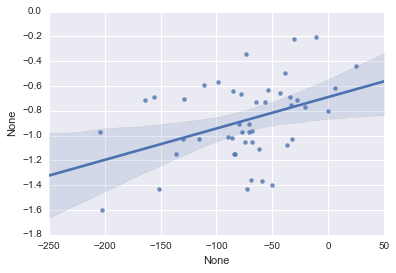

In [105]:
sns.regplot(rea_energy_beta, rec_energy_beta[(-2, 2, -4, 4)])

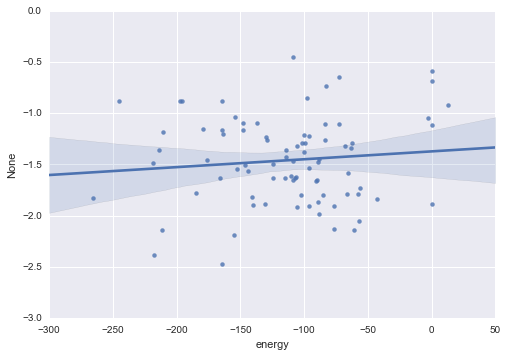

In [30]:
sns.regplot(grouped.energy.apply(sum),(rec_energy_alpha[(-2, 0, -4, 4)] + rec_energy_beta[(-2, 2, -4, 4)]))

In [31]:
temp = grouped.energy.apply(sum)
np.corrcoef(temp,(rec_energy_alpha[(-2, 0, -4, 4)] + rec_energy_beta[(-2, 2, -4, 4)]))

array([[ 1.        ,  0.10487194],
       [ 0.10487194,  1.        ]])

In [370]:
#def calc_energy_final(grouped, ag_left=-3, ag_right=2, tcr_left=-3, tcr_right=1):
#def calc_energy_final_alpha(grouped, ag_left=0, ag_right=3, tcr_left=-3, tcr_right=3):
def calc_energy_final_alpha(grouped, ag_left=-1, ag_right=1, tcr_left=-1, tcr_right=1):
    return calc_energy_bryant3(grouped, ag_left, ag_right, tcr_left, tcr_right)

def  calc_energy_final_beta(grouped, ag_left=0, ag_right=1, tcr_left=-3, tcr_right=3):
    return calc_energy_bryant1(grouped, ag_left, ag_right, tcr_left, tcr_right)

In [372]:
def proc_line(x, anti):
    columns=['pdb_id', 'tcr_v_allele', 'aa_tcr', 'aa_antigen', 'pos_tcr', 'pos_antigen']
    #anti = x['antigen_seq']
    cdr3 = x['tcr_region_seq']
    name = x['pdb_id']
    alle = x['tcr_v_allele']
    res = []
    for pos_tcr in range(len(cdr3)):
        for pos_antigen in range(len(anti)):
            aa_tcr = cdr3[pos_tcr]
            aa_antigen = anti[pos_antigen]
            res.append([name, alle, aa_tcr, aa_antigen, pos_tcr, pos_antigen])
    res = pd.DataFrame(res, columns=columns)
    res.loc[:, 'pos_tcr'] -= np.floor(len(cdr3) / 2)
    res.loc[:, 'pos_antigen'] -= np.floor(len(anti) / 2)
    return res

def get_mutant_alpha_beta(antigen):
    table = df[['pdb_id', 'mhc_type', 'antigen_seq', 'tcr_v_allele', 'tcr_region', 'tcr_region_seq']].copy()
    table = table.drop_duplicates()
    table = pd.concat([proc_line(table.iloc[i, :], antigen) for i in range(table.shape[0])])
    table_grouped = table.groupby('pdb_id')
    return calc_energy_final_alpha(table_grouped), calc_energy_final_beta(table_grouped)

In [380]:
alpha_energy, beta_energy = get_mutant_alpha_beta('ELAGIGILTV')

In [404]:
plt.figure(figsize=(16, 7))
plt.plot(alpha_energy.apply(min) + beta_energy.apply(min), 'ro', c=map(int,alpha_energy.index.isin(['4p2q'])))
plt.xticks(range(len(alpha_energy)), alpha_energy.index, rotation=60);
plt.tight_layout()

ValueError: to_rgba: Invalid rgba arg "[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
length of rgba sequence should be either 3 or 4

Now we will try to distinguish real cdr3-antigen pairs from mixed ones with Bryant potential

In [38]:
vdjdb_melt = pd.read_csv('vdjdb_melt.csv')
vdjdb_melt_mixed = pd.read_csv('vdjdb_melt_mixed.csv')
vdjdb_melt = vdjdb_melt[vdjdb_melt['tcr_v_allele'] == 'beta']
vdjdb_melt_mixed = vdjdb_melt_mixed[vdjdb_melt_mixed['tcr_v_allele'] == 'beta']

In [62]:
grouped_unmix = vdjdb_melt.groupby('tcr_id')
grouped_mix = vdjdb_melt_mixed.groupby('tcr_id')
unmixed_energy_many = calc_energy_final(grouped_unmix)
mixed_energy_many = calc_energy_final(grouped_mix)

Nethertheless, following the same procedure, this Bryant potential does not seem to be able to discriminate false and true antigens by energy distibution.

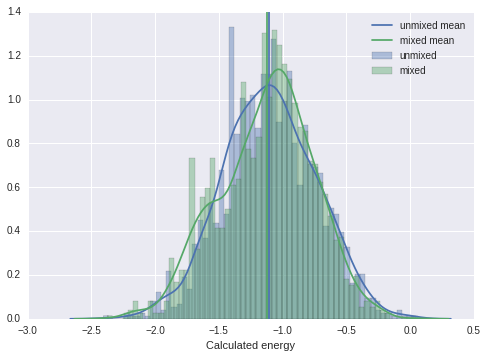

In [63]:
unmixed_energy_min = [min(i) for i in unmixed_energy_many]
mixed_energy_min = [min(i) for i in mixed_energy_many]
ax = sns.distplot(unmixed_energy_min, bins=60, kde=True, label='unmixed')       
plt.axvline(np.mean(unmixed_energy_min), color=ax.get_lines()[0].get_c(), label='unmixed mean')
ax = sns.distplot(mixed_energy_min, bins=60, kde=True, label='mixed')       
plt.axvline(np.mean(mixed_energy_min), color=ax.get_lines()[2].get_c(), label='mixed mean')
plt.xlabel('Calculated energy'); plt.legend();

Mixing antigens in vdjdb table was not fruitful, energy distributions are almost identical. Next the distributions for sigle antigens will be constructed.

In [39]:
energy_EPLPQGQLTAY = get_mutant('EPLPQGQLTAY', 'EPLPQGQLTAY')
energy_KAFSPEVIPMF = get_mutant('KAFSPEVIPMF', 'KAFSPEVIPMF')
energy_GLCTLVAML = get_mutant('GLCTLVAML', 'GLCTLVAML')
energy_EIYKRWII = get_mutant('EIYKRWII', 'EIYKRWII')
energy_RPRGEVRFL = get_mutant('RPRGEVRFL', 'RPRGEVRFL')
energy_RAKFKQLL = get_mutant('RAKFKQLL', 'RAKFKQLL')
energy_TPRVTGGGAM = get_mutant('TPRVTGGGAM', 'TPRVTGGGAM')
energy_GLNKIVRMY = get_mutant('GLNKIVRMY', 'GLNKIVRMY')
energy_EPLPQGQLTAY_WRONGS_CDR3S = get_mutant('KAFSPEVIPMF', 'EPLPQGQLTAY')
energy_KAFSPEVIPMF_WRONGS_CDR3S = get_mutant('GLCTLVAML', 'KAFSPEVIPMF')
energy_GLCTLVAML_WRONGS_CDR3S = get_mutant('EIYKRWII', 'GLCTLVAML')
energy_EIYKRWII_WRONGS_CDR3S = get_mutant('RPRGEVRFL', 'EIYKRWII')
energy_RPRGEVRFL_WRONGS_CDR3S = get_mutant('RAKFKQLL', 'RPRGEVRFL')
energy_RAKFKQLL_WRONGS_CDR3S = get_mutant('TPRVTGGGAM', 'RAKFKQLL')
energy_TPRVTGGGAM_WRONGS_CDR3S = get_mutant('GLNKIVRMY', 'TPRVTGGGAM')
energy_GLNKIVRMY_WRONGS_CDR3S = get_mutant('EPLPQGQLTAY', 'GLNKIVRMY')

In [40]:
def distplot_energy_mins(energies, name):
    energy_mins = [min(x) for x in energies]
    ax = sns.distplot(np.array(energy_mins), bins=30, label=name)       
    plt.axvline(np.mean(energy_mins), c=ax.get_lines()[-1].get_c())
    plt.legend()
    
def kdeplot_energy_mins(energies, name):
    energy_mins = [min(x) for x in energies]
    ax = sns.kdeplot(np.array(energy_mins), shade=True, label=name)       
    plt.axvline(np.mean(energy_mins), c=ax.get_lines()[-1].get_c())
    plt.legend()
    
def kdeplot(vals, name):
    ax = sns.kdeplot(np.array(vals), shade=True, label=name)       
    plt.axvline(np.mean(vals), c=ax.get_lines()[-1].get_c())
    plt.legend()
    
def distplot(vals, name):
    ax = sns.distplot(np.array(vals), bins=30, label=name)       
    plt.axvline(np.mean(vals), c=ax.get_lines()[-1].get_c())
    plt.legend()

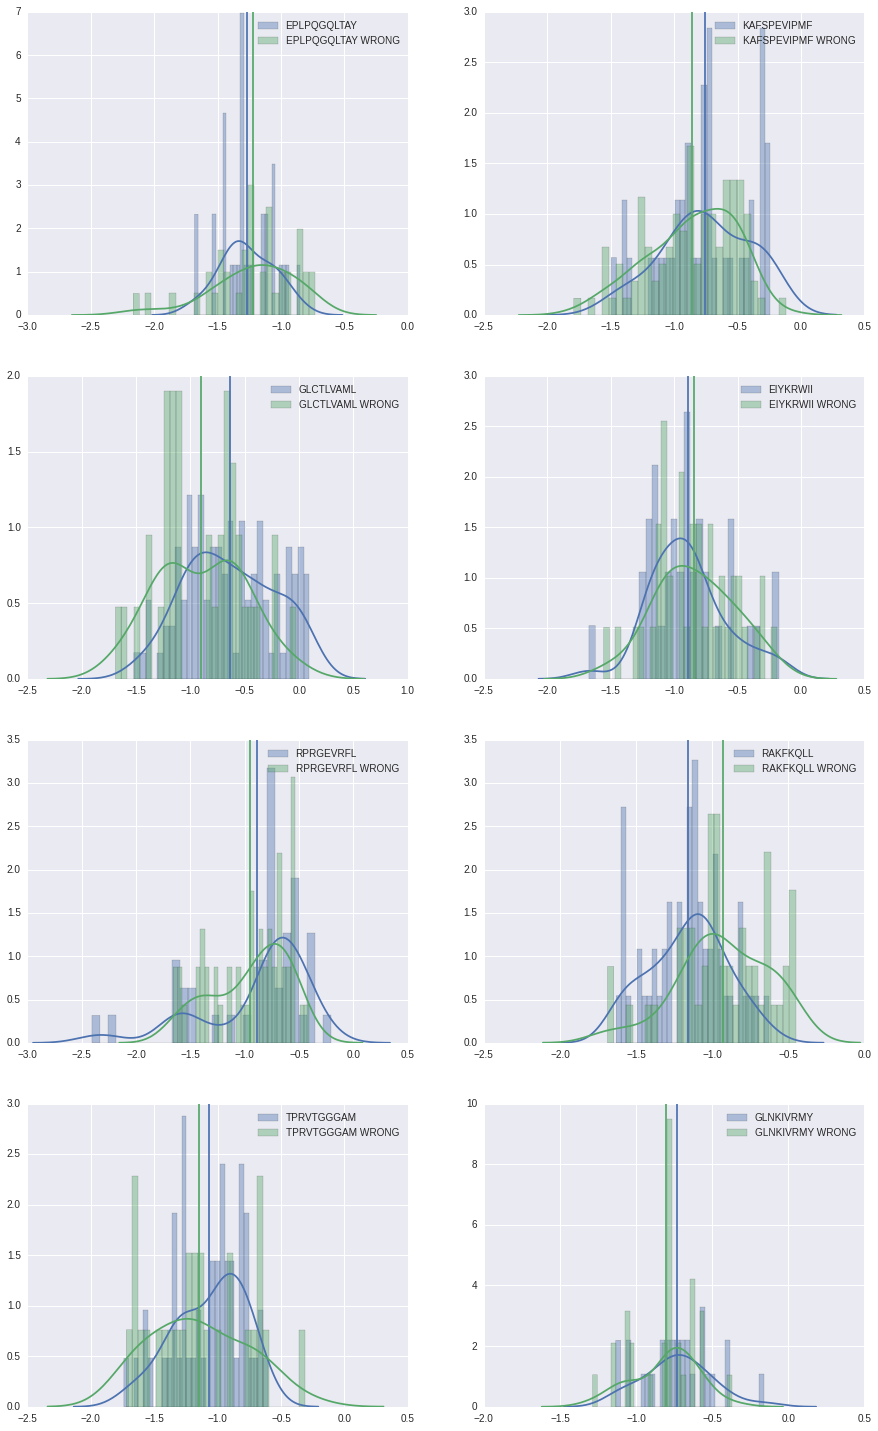

In [41]:
plt.figure(figsize=(15, 25))
plt.subplot(421)
distplot_energy_mins(energy_EPLPQGQLTAY, 'EPLPQGQLTAY')
distplot_energy_mins(energy_EPLPQGQLTAY_WRONGS_CDR3S, 'EPLPQGQLTAY WRONG')

plt.subplot(422)
distplot_energy_mins(energy_KAFSPEVIPMF, 'KAFSPEVIPMF')
distplot_energy_mins(energy_KAFSPEVIPMF_WRONGS_CDR3S, 'KAFSPEVIPMF WRONG')

plt.subplot(423)
distplot_energy_mins(energy_GLCTLVAML, 'GLCTLVAML')
distplot_energy_mins(energy_GLCTLVAML_WRONGS_CDR3S, 'GLCTLVAML WRONG')

plt.subplot(424)
distplot_energy_mins(energy_EIYKRWII, 'EIYKRWII')
distplot_energy_mins(energy_EIYKRWII_WRONGS_CDR3S, 'EIYKRWII WRONG')

plt.subplot(425)
distplot_energy_mins(energy_RPRGEVRFL, 'RPRGEVRFL')
distplot_energy_mins(energy_RPRGEVRFL_WRONGS_CDR3S, 'RPRGEVRFL WRONG')

plt.subplot(426)
distplot_energy_mins(energy_RAKFKQLL, 'RAKFKQLL')
distplot_energy_mins(energy_RAKFKQLL_WRONGS_CDR3S, 'RAKFKQLL WRONG')

plt.subplot(427)
distplot_energy_mins(energy_TPRVTGGGAM, 'TPRVTGGGAM')
distplot_energy_mins(energy_TPRVTGGGAM_WRONGS_CDR3S, 'TPRVTGGGAM WRONG')

plt.subplot(428)
distplot_energy_mins(energy_GLNKIVRMY, 'GLNKIVRMY')
distplot_energy_mins(energy_GLNKIVRMY_WRONGS_CDR3S, 'GLNKIVRMY WRONG')

Upper for each single picture cdr3 set remained unchanged and distribution was plotted for false and true antigen.
Further we will keep antigen and will change the cdr3 set.

In [28]:
# For antigen EPLPQGQLTAY
EPLPQGQLTAY_CDR3S_FROM_EPLPQGQLTAY = get_mutant('EPLPQGQLTAY', 'EPLPQGQLTAY')
EPLPQGQLTAY_CDR3S_FROM_KAFSPEVIPMF = get_mutant('KAFSPEVIPMF', 'EPLPQGQLTAY')
EPLPQGQLTAY_CDR3S_FROM_GLCTLVAML = get_mutant('GLCTLVAML', 'EPLPQGQLTAY')
EPLPQGQLTAY_CDR3S_FROM_EIYKRWII = get_mutant('EIYKRWII', 'EPLPQGQLTAY')

# For antigen RPRGEVRFL
RPRGEVRFL_CDR3S_FROM_RPRGEVRFL = get_mutant('RPRGEVRFL', 'RPRGEVRFL')
RPRGEVRFL_CDR3S_FROM_RAKFKQLL = get_mutant('RAKFKQLL', 'RPRGEVRFL')
RPRGEVRFL_CDR3S_FROM_TPRVTGGGAM = get_mutant('TPRVTGGGAM', 'RPRGEVRFL')
RPRGEVRFL_CDR3S_FROM_GLNKIVRMY = get_mutant('GLNKIVRMY', 'RPRGEVRFL')

# For antigen TPRVTGGGAM
TPRVTGGGAM_CDR3S_FROM_TPRVTGGGAM = get_mutant('TPRVTGGGAM', 'TPRVTGGGAM')
TPRVTGGGAM_CDR3S_FROM_RPRGEVRFL = get_mutant('RPRGEVRFL', 'TPRVTGGGAM')
TPRVTGGGAM_CDR3S_FROM_KAFSPEVIPMF = get_mutant('KAFSPEVIPMF', 'TPRVTGGGAM')
TPRVTGGGAM_CDR3S_FROM_EIYKRWII = get_mutant('EIYKRWII', 'TPRVTGGGAM')

/home/mikhail/Development/Libs/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


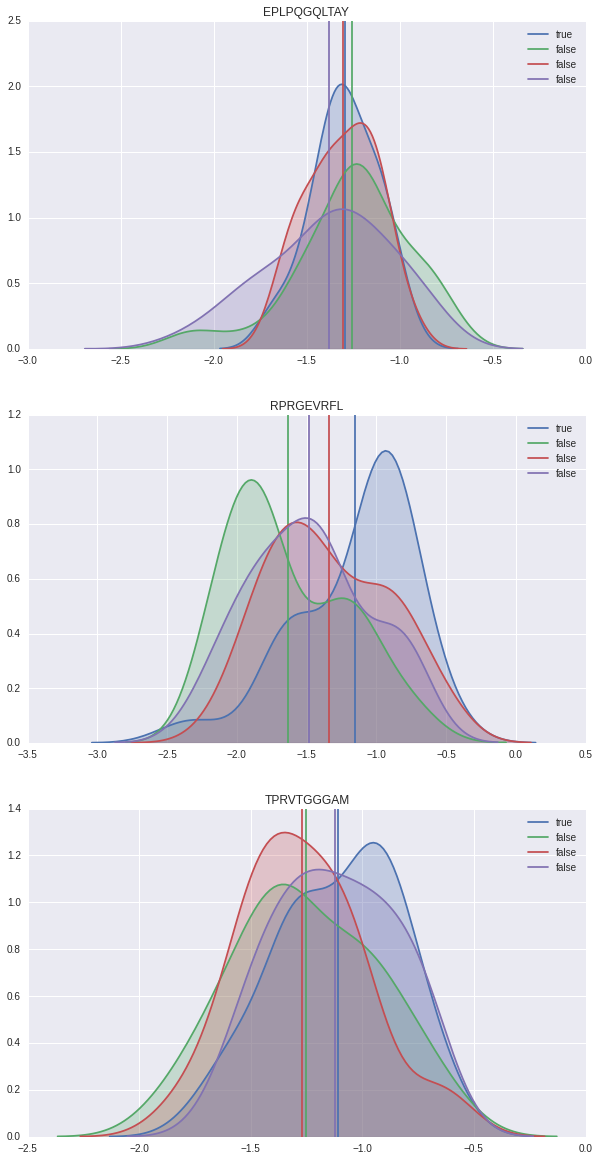

In [29]:
plt.figure(figsize=(10, 20))
plt.subplot(311)
kdeplot_energy_mins(EPLPQGQLTAY_CDR3S_FROM_EPLPQGQLTAY, 'true')
kdeplot_energy_mins(EPLPQGQLTAY_CDR3S_FROM_KAFSPEVIPMF, 'false')
kdeplot_energy_mins(EPLPQGQLTAY_CDR3S_FROM_GLCTLVAML, 'false')
kdeplot_energy_mins(EPLPQGQLTAY_CDR3S_FROM_EIYKRWII, 'false')
plt.title('EPLPQGQLTAY')

plt.subplot(312)
kdeplot_energy_mins(RPRGEVRFL_CDR3S_FROM_RPRGEVRFL, 'true')
kdeplot_energy_mins(RPRGEVRFL_CDR3S_FROM_RAKFKQLL, 'false')
kdeplot_energy_mins(RPRGEVRFL_CDR3S_FROM_TPRVTGGGAM, 'false')
kdeplot_energy_mins(RPRGEVRFL_CDR3S_FROM_GLNKIVRMY, 'false')
plt.title('RPRGEVRFL')

plt.subplot(313)
kdeplot_energy_mins(TPRVTGGGAM_CDR3S_FROM_TPRVTGGGAM, 'true')
kdeplot_energy_mins(TPRVTGGGAM_CDR3S_FROM_RPRGEVRFL, 'false')
kdeplot_energy_mins(TPRVTGGGAM_CDR3S_FROM_KAFSPEVIPMF, 'false')
kdeplot_energy_mins(TPRVTGGGAM_CDR3S_FROM_EIYKRWII, 'false')
plt.title('TPRVTGGGAM')

Plots do not show any apparent difference for the case where antigen is assigned to its real cdr3s (true) and the case where cdr3s are changed (false), except that the true case shows the greatest mean energy value too often. This is strange.
So the ideas are:
* maybe energy should not be considered in terms of mean value and this approach may still work out, if one accounts for every single cdr3-antigen pair, and not for the group of them
* maybe the problem is that alpha-chain is ignored. the energy for cdr3-antigen pair should be calculated as a sum of alpha and beta, but for to assert that, we need table with alpha-beta pairs
___

Now we take a set of cdr3s and calculate energy for each cdr3 first with its genuine antigen, then with three false antigens. Then we substract lists of energies with false antigens from list with true energies elementwisely and get module of energy difference distribution for false antigens in comparison with the true one.

In [30]:
def list_substract(a, b):
    return [a_i - b_i for a_i, b_i in zip(a, b)]

def align_sets(set1, set2):
    return np.mean([np.max([pairwise2.align.globalxx(a, b)[0][2] / max(len(b), len(a)) for b in set2]) for a in set1])

def align_antigens(a, b):
    return align_sets(vdjdb[vdjdb.antigen == a].cdr3, vdjdb[vdjdb.antigen == b].cdr3)

In [31]:
EPLPQGQLTAY_CDR3S_FROM_EPLPQGQLTAY_MINS = [min(x) for x in get_mutant('EPLPQGQLTAY', 'EPLPQGQLTAY')]
KAFSPEVIPMF_CDR3S_FROM_EPLPQGQLTAY_MINS = [min(x) for x in get_mutant('EPLPQGQLTAY', 'KAFSPEVIPMF')]
GLCTLVAML_CDR3S_FROM_EPLPQGQLTAY_MINS = [min(x) for x in get_mutant('EPLPQGQLTAY', 'GLCTLVAML')]
EIYKRWII_CDR3S_FROM_EPLPQGQLTAY_MINS = [min(x) for x in get_mutant('EPLPQGQLTAY', 'EIYKRWII')]

RPRGEVRFL_CDR3S_FROM_RPRGEVRFL_MINS = [min(x) for x in get_mutant('RPRGEVRFL', 'RPRGEVRFL')]
RAKFKQLL_CDR3S_FROM_RPRGEVRFL_MINS = [min(x) for x in get_mutant('RPRGEVRFL', 'RAKFKQLL')]
TPRVTGGGAM_CDR3S_FROM_RPRGEVRFL_MINS = [min(x) for x in get_mutant('RPRGEVRFL', 'TPRVTGGGAM')]
GLNKIVRMY_CDR3S_FROM_RPRGEVRFL_MINS = [min(x) for x in get_mutant('RPRGEVRFL', 'GLNKIVRMY')]

TPRVTGGGAM_CDR3S_FROM_TPRVTGGGAM_MINS = [min(x) for x in get_mutant('TPRVTGGGAM', 'TPRVTGGGAM')]
RPRGEVRFL_CDR3S_FROM_TPRVTGGGAM_MINS = [min(x) for x in get_mutant('TPRVTGGGAM', 'RPRGEVRFL')]
KAFSPEVIPMF_CDR3S_FROM_TPRVTGGGAM_MINS = [min(x) for x in get_mutant('TPRVTGGGAM', 'KAFSPEVIPMF')]
EIYKRWII_CDR3S_FROM_TPRVTGGGAM_MINS = [min(x) for x in get_mutant('TPRVTGGGAM', 'EIYKRWII')]

In [32]:
GLNKIVRMY_CDR3S_FROM_GLNKIVRMY_MINS = [min(x) for x in get_mutant('GLNKIVRMY', 'GLNKIVRMY')]
IPSINVHHY_CDR3S_FROM_GLNKIVRMY_MINS = [min(x) for x in get_mutant('GLNKIVRMY', 'IPSINVHHY')]
KRWIILGLNK_CDR3S_FROM_GLNKIVRMY_MINS = [min(x) for x in get_mutant('GLNKIVRMY', 'KRWIILGLNK')]
QIKVRVDMV_CDR3S_FROM_GLNKIVRMY_MINS = [min(x) for x in get_mutant('GLNKIVRMY', 'QIKVRVDMV')]

IPSINVHHY_CDR3S_FROM_IPSINVHHY_MINS = [min(x) for x in get_mutant('IPSINVHHY', 'IPSINVHHY')]
GLNKIVRMY_CDR3S_FROM_IPSINVHHY_MINS = [min(x) for x in get_mutant('IPSINVHHY', 'GLNKIVRMY')]
KRWIILGLNK_CDR3S_FROM_IPSINVHHY_MINS = [min(x) for x in get_mutant('IPSINVHHY', 'KRWIILGLNK')]
QIKVRVDMV_CDR3S_FROM_IPSINVHHY_MINS = [min(x) for x in get_mutant('IPSINVHHY', 'QIKVRVDMV')]

Plots show the distribution of energy deviation in case when a real antigen is changed to other one. They also reflect mean value and standart deviation of this distribution. For example, blue distribution on the first plot shows energy deviation when the CDR3s, which belong to EPLPQGQLTAY, are imposed on KAFSPEVIPMF antigen. 'CDR3 dif-ce' stands for the similatiry of CDR3 sets for true antigen and false antigen in vdjdb. 1 means that sets are equal, 0 means that sets are very far from each other.

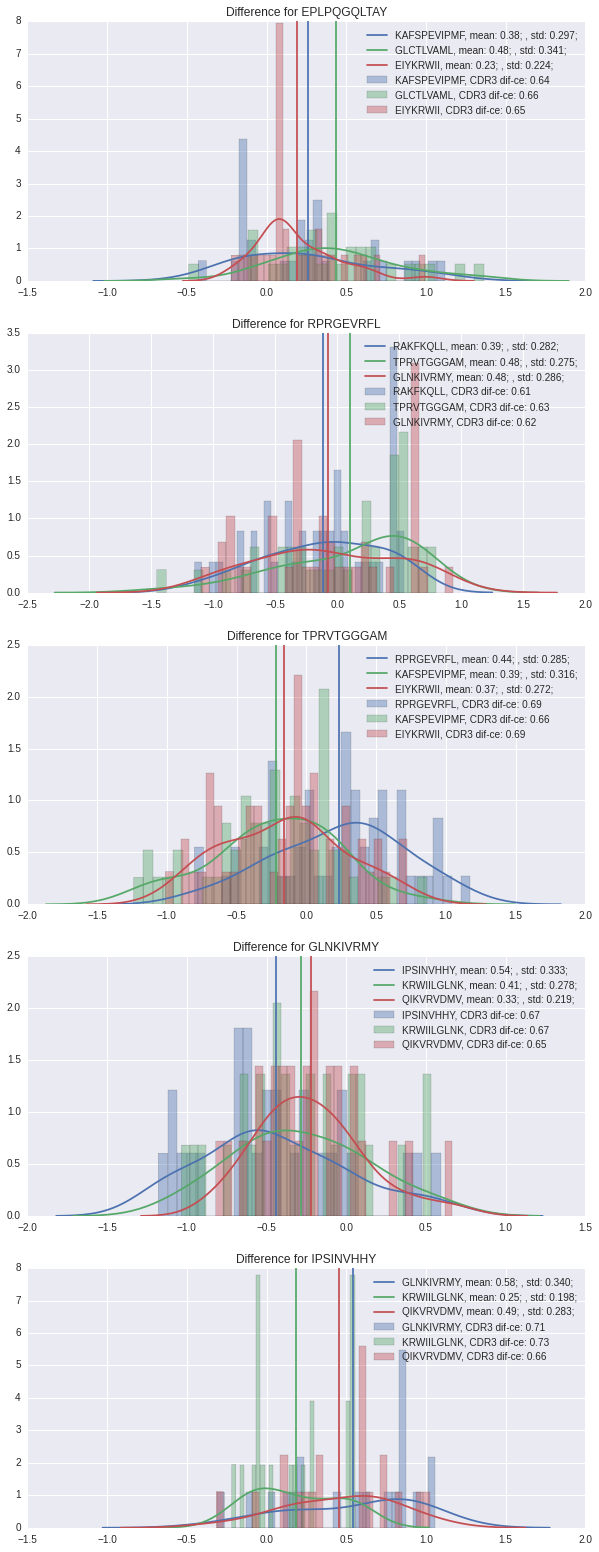

In [33]:
def plot_difference(a, b, true_anti, false_anti):
    subs = list_substract(a, b)
    cdr3dist = align_antigens(true_anti, false_anti)
    name = false_anti + ', CDR3 dif-ce: ' + '%.2f' % cdr3dist
    mean = np.mean(map(abs, subs))
    std = np.std(map(abs, subs))
    ax = sns.distplot(np.array(subs), bins=30, label=name)       
    plt.axvline(np.mean(subs), c=ax.get_lines()[-1].get_c(), \
                label=false_anti + ', mean: %.2f; ' % mean + ', std: %.3f;' % std)
    plt.legend()
    plt.title('Difference for ' + true_anti)
    return (true_anti, false_anti, map(abs, subs), cdr3dist)
    
nrg_dev = []

plt.figure(figsize=(10, 27))
plt.subplot(511)
nrg_dev.append(plot_difference(KAFSPEVIPMF_CDR3S_FROM_EPLPQGQLTAY_MINS, EPLPQGQLTAY_CDR3S_FROM_EPLPQGQLTAY_MINS, 'EPLPQGQLTAY', 'KAFSPEVIPMF'))
nrg_dev.append(plot_difference(GLCTLVAML_CDR3S_FROM_EPLPQGQLTAY_MINS, EPLPQGQLTAY_CDR3S_FROM_EPLPQGQLTAY_MINS, 'EPLPQGQLTAY', 'GLCTLVAML'))
nrg_dev.append(plot_difference(EIYKRWII_CDR3S_FROM_EPLPQGQLTAY_MINS, EPLPQGQLTAY_CDR3S_FROM_EPLPQGQLTAY_MINS, 'EPLPQGQLTAY', 'EIYKRWII'))

plt.subplot(512)
nrg_dev.append(plot_difference(RPRGEVRFL_CDR3S_FROM_RPRGEVRFL_MINS, RAKFKQLL_CDR3S_FROM_RPRGEVRFL_MINS, 'RPRGEVRFL', 'RAKFKQLL'))
nrg_dev.append(plot_difference(RPRGEVRFL_CDR3S_FROM_RPRGEVRFL_MINS, TPRVTGGGAM_CDR3S_FROM_RPRGEVRFL_MINS, 'RPRGEVRFL', 'TPRVTGGGAM'))
nrg_dev.append(plot_difference(RPRGEVRFL_CDR3S_FROM_RPRGEVRFL_MINS, GLNKIVRMY_CDR3S_FROM_RPRGEVRFL_MINS, 'RPRGEVRFL', 'GLNKIVRMY'))

plt.subplot(513)
nrg_dev.append(plot_difference(TPRVTGGGAM_CDR3S_FROM_TPRVTGGGAM_MINS, RPRGEVRFL_CDR3S_FROM_TPRVTGGGAM_MINS, 'TPRVTGGGAM', 'RPRGEVRFL'))
nrg_dev.append(plot_difference(TPRVTGGGAM_CDR3S_FROM_TPRVTGGGAM_MINS, KAFSPEVIPMF_CDR3S_FROM_TPRVTGGGAM_MINS, 'TPRVTGGGAM', 'KAFSPEVIPMF'))
nrg_dev.append(plot_difference(TPRVTGGGAM_CDR3S_FROM_TPRVTGGGAM_MINS, EIYKRWII_CDR3S_FROM_TPRVTGGGAM_MINS, 'TPRVTGGGAM', 'EIYKRWII'))

plt.subplot(514)
nrg_dev.append(plot_difference(GLNKIVRMY_CDR3S_FROM_GLNKIVRMY_MINS, IPSINVHHY_CDR3S_FROM_GLNKIVRMY_MINS, 'GLNKIVRMY', 'IPSINVHHY'))
nrg_dev.append(plot_difference(GLNKIVRMY_CDR3S_FROM_GLNKIVRMY_MINS, KRWIILGLNK_CDR3S_FROM_GLNKIVRMY_MINS, 'GLNKIVRMY', 'KRWIILGLNK'))
nrg_dev.append(plot_difference(GLNKIVRMY_CDR3S_FROM_GLNKIVRMY_MINS, QIKVRVDMV_CDR3S_FROM_GLNKIVRMY_MINS, 'GLNKIVRMY', 'QIKVRVDMV'))

plt.subplot(515)
nrg_dev.append(plot_difference(IPSINVHHY_CDR3S_FROM_IPSINVHHY_MINS, GLNKIVRMY_CDR3S_FROM_IPSINVHHY_MINS, 'IPSINVHHY', 'GLNKIVRMY'))
nrg_dev.append(plot_difference(IPSINVHHY_CDR3S_FROM_IPSINVHHY_MINS, KRWIILGLNK_CDR3S_FROM_IPSINVHHY_MINS, 'IPSINVHHY', 'KRWIILGLNK'))
nrg_dev.append(plot_difference(IPSINVHHY_CDR3S_FROM_IPSINVHHY_MINS, QIKVRVDMV_CDR3S_FROM_IPSINVHHY_MINS, 'IPSINVHHY', 'QIKVRVDMV'));

Now we can see that there exists correlation between CDR3 sets similarity and energy deviation after changing the antigen. This means that the less CDR3 sets of two antigens have in common, the more interaction energy deviates after changing the true antigen.

/home/mikhail/Development/Libs/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


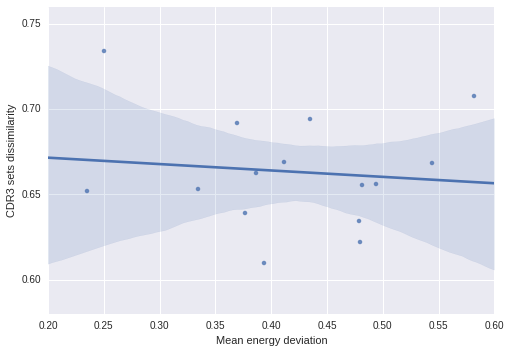

In [34]:
mean_deviation = [np.mean(x[2]) for x in nrg_dev]
sets_dissimilarity = [x[3] for x in nrg_dev]
sns.regplot(np.array(mean_deviation), np.array(sets_dissimilarity))
plt.xlabel('Mean energy deviation'); plt.ylabel('CDR3 sets dissimilarity'); plt.legend()

In [35]:
print 'Energy deviates by %.2f +- %.2f kJ/mol on average' % (np.mean(reduce(lambda x, y: x + y, [x[2] for x in nrg_dev])), 
                                                             np.std(reduce(lambda x, y: x + y, [x[2] for x in nrg_dev])))

Energy deviates by 0.41 +- 0.30 kJ/mol on average
